In [1]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from tensorflow.keras.regularizers import l2

2024-05-28 03:49:44.951752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 03:49:44.951871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 03:49:45.077032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Loading the dataset directly
with h5py.File("/kaggle/input/preprocessed-glomeruli-dataset/Dataset.h5", 'r') as hf:
    x_train, x_test, y_train, y_test = train_test_split(hf['image_vector'][:6500], hf['glomeruli_type'][:6500], test_size=0.3, stratify=hf['glomeruli_type'][:6500], random_state=35)

In [6]:
# Defining the input layer to process the image vectors
input_layer = Input(shape=(300, 300, 3))

In [7]:
# Loading the EfficientNetB3 model with no pre-trained weights. 
base_model = EfficientNetB3(include_top=False, input_tensor=input_layer, weights=None)

In [8]:
# Adding a custome last layer, which is the output layer.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

In [9]:
# Creating the Initial Model.
model = Model(inputs=base_model.input, outputs=output_layer)
# Freezing the base model layers Initially, to avoid any learning
for layer in base_model.layers:
    layer.trainable = False
# Compiling the Model.
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
# Setting main Hyperparameters for initial training
batches = 16
total_epochs = 5

In [35]:
# Training the model
b3ic = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=total_epochs,
    batch_size = batches, 
    )

Epoch 1/5
  1/285 ━━━━━━━━━━━━━━━━━━━━ 5:14:18 66s/step - accuracy: 0.3750 - loss: 0.7136

I0000 00:00:1716864080.190953     189 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716864080.265978     189 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7319 - loss: 0.6181

W0000 00:00:1716864145.275032     189 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716864159.920905     189 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 166s 352ms/step - accuracy: 0.7319 - loss: 0.6180 - val_accuracy: 0.7385 - val_loss: 0.5823
Epoch 2/5
  1/285 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - accuracy: 0.6875 - loss: 0.6338

W0000 00:00:1716864180.339607     190 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7466 - loss: 0.5753 - val_accuracy: 0.7385 - val_loss: 0.5817
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7447 - loss: 0.5761 - val_accuracy: 0.7385 - val_loss: 0.5800
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7423 - loss: 0.5760 - val_accuracy: 0.7385 - val_loss: 0.5782
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7346 - loss: 0.5836 - val_accuracy: 0.7385 - val_loss: 0.5796


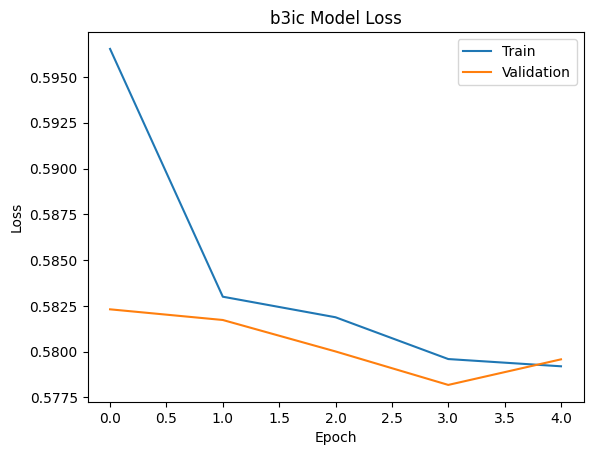

In [36]:
# Analyzing the performance (accuracy) of the trained model, over number of epochs.
plt.plot(b3ic.history['loss'])
plt.plot(b3ic.history['val_loss'])
plt.title('b3ic Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

After initially training the model, we are left with fine tuning the model. However, the RAM would not be sufficient to accomodate the fine tuning of the model, while also accomodating the dataset used earlier. Thus, we save the model, and then restart the session, and load the saved model directly, which allows us to fine tune the model, as the RAM would be sufficient enough to accomodate both dataset as well as fine tuning of the model. 

In [37]:
# Saving the trained model for fine tuning.
model.save('b3ic.keras')

# Restart the Session

In [27]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py
import gc
import seaborn as sns
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Loading the dataset directly
with h5py.File("/kaggle/input/preprocessed-glomeruli-dataset/Dataset.h5", 'r') as hf:
    x_train, x_test, y_train, y_test = train_test_split(hf['image_vector'][:6500], hf['glomeruli_type'][:6500], test_size=0.3, stratify=hf['glomeruli_type'][:6500], random_state=35)

In [4]:
# Loading the pre-trained model
model = load_model('b3ic.keras')

In [ ]:
# Summary of Model
# model.summary()

In [5]:
# Unfreeze some layers and fine-tune the model
for layer in model.layers[:-10]:
    layer.trainable = True
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# Setting main Hyperparameters for Fine tuning
fine_tune_batches = 16
fine_tune_epochs = 7

In [7]:
# Re-training the Model
fine_tuned_b3ic = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=fine_tune_epochs,
    batch_size = fine_tune_batches
)

Epoch 1/7


I0000 00:00:1716870431.421013    3010 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716870431.575722    3010 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8098 - loss: 0.4552

W0000 00:00:1716870597.862459    3010 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716870613.426609    3010 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 377s 713ms/step - accuracy: 0.8099 - loss: 0.4549 - val_accuracy: 0.2615 - val_loss: 5.4089
Epoch 2/7


W0000 00:00:1716870634.190182    3010 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


285/285 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9175 - loss: 0.2368 - val_accuracy: 0.2662 - val_loss: 2.1190
Epoch 3/7
285/285 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.9308 - loss: 0.1986 - val_accuracy: 0.7636 - val_loss: 1.2508
Epoch 4/7
285/285 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9518 - loss: 0.1546 - val_accuracy: 0.6918 - val_loss: 1.4340
Epoch 5/7
285/285 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9569 - loss: 0.1376 - val_accuracy: 0.3205 - val_loss: 2.1104
Epoch 6/7
285/285 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9599 - loss: 0.1333 - val_accuracy: 0.8564 - val_loss: 2.7983
Epoch 7/7
285/285 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9394 - loss: 0.2158 - val_accuracy: 0.9677 - val_loss: 0.1102


In [ ]:
# Saving the fine tuned model as "final-b3ic.keras"
model.save('final-b3ic.keras')

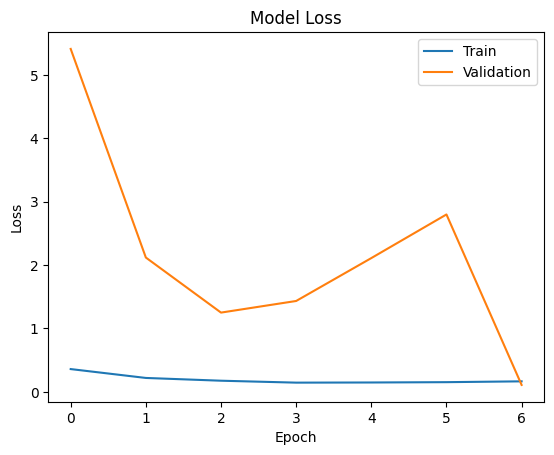

In [8]:
# Analyzing the performance (accuracy) of the fine tuned model, over epochs.
plt.plot(fine_tuned_b3ic.history['loss'])
plt.plot(fine_tuned_b3ic.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [9]:
# Predicting the output on test dataset, to evaluate the performance(using metrics such as Accuracy, Precision, Recall, etc).
y_pred = model.predict(x_test)

 2/61 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step 

W0000 00:00:1716871155.496649    3010 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


61/61 ━━━━━━━━━━━━━━━━━━━━ 51s 479ms/step


W0000 00:00:1716871184.241306    3011 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [11]:
# Converting every predicted output into 0s if the output value is less than 0.5, else 1 otherwise.
y_pred = (y_pred > 0.5).astype(int)
print(y_pred)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]


In [12]:
# Calculating precision and recall.
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
# Computing confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [15]:
print(f'Precision: {precision}\nRecall: {recall}\nConfusion Matrix:\n {conf_matrix}')

Precision: 0.9687823364243329
Recall: 0.9676923076923077
Confusion Matrix:
 [[1394   46]
 [  17  493]]


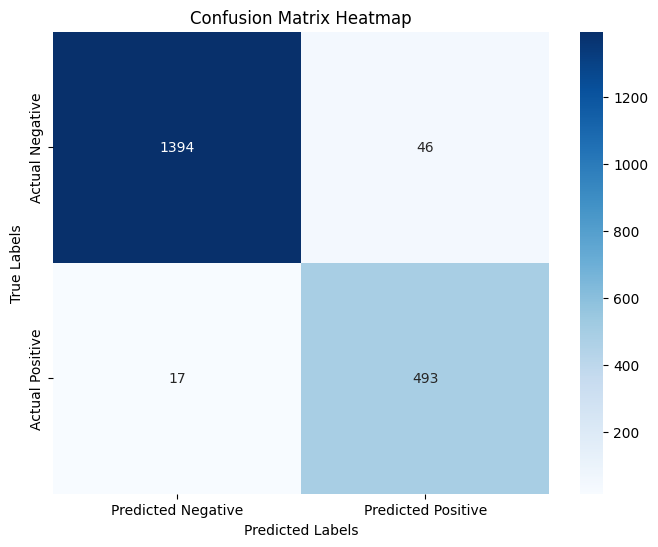

In [16]:
# Plotting Heatmap, to show Confusion Matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [23]:
del x_train
del x_test
del y_train
del y_test
gc.collect()

8341

In [19]:
# Testing on Unknown Dataset
with h5py.File("/kaggle/input/preprocessed-glomeruli-dataset/Dataset.h5", 'r') as hf:
    unknown_data_input, unknown_data_output = hf['image_vector'][6500:], hf['glomeruli_type'][6500:]

In [25]:
unknown_dataset_pred = model.predict(unknown_data_input)

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step


W0000 00:00:1716872147.946773    3013 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
unknown_dataset_pred = (unknown_dataset_pred > 0.5).astype(int)

In [29]:
# Calculating accuracy, precision and recall.
udp_accuracy = accuracy_score(unknown_data_output, unknown_dataset_pred)
udp_precision = precision_score(unknown_data_output, unknown_dataset_pred, average='weighted')
udp_recall = recall_score(unknown_data_output, unknown_dataset_pred, average='weighted')
# Computing confusion matrix
udp_conf_matrix = confusion_matrix(unknown_data_output, unknown_dataset_pred)

In [31]:
print(f'Accuracy: {udp_accuracy}\nPrecision: {udp_precision}\nRecall: {udp_recall}\nConfusion Matrix:\n {udp_conf_matrix}')

Accuracy: 0.9563172043010753
Precision: 0.9594707226648759
Recall: 0.9563172043010753
Confusion Matrix:
 [[1026   54]
 [  11  397]]
